In [1]:
# Import essential libraries for data analysis, visualization, and modeling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
from scipy.stats import norm
import seaborn as sns
from tabulate import tabulate
import statsmodels.api as sm
import cvxpy as cp

In [2]:
#Fetching Close and Return data
def fetch_data(tickers, start=None, end=None):
    # Validate start date
    if not start:
        raise ValueError("❌ Start date is required in 'YYYY-MM-DD' format.")
    try:
        datetime.strptime(start, "%Y-%m-%d")
    except ValueError:
        raise ValueError("❌ Start date must be in 'YYYY-MM-DD' format (e.g., 2020-01-01).")

    # Validate end date if provided
    if end:
        try:
            datetime.strptime(end, "%Y-%m-%d")
        except ValueError:
            raise ValueError("❌ End date must be in 'YYYY-MM-DD' format (e.g., 2020-12-31).")

    data = yf.download(tickers, start=start, end=end, group_by='ticker', interval='1mo', auto_adjust=True)

    # Handle both single and multi-level column format
    if isinstance(data.columns, pd.MultiIndex):
        try:
            adj_close = data.xs('Close', level=1, axis=1)
        except KeyError:
            raise ValueError("❌ 'Adj Close' prices not found — possibly all tickers failed.")
    else:
        if 'Close' in data.columns:
            adj_close = data['Close'].to_frame()
        else:
            raise ValueError("❌ No 'Adj Close' in single-column format.")

    adj_close = adj_close.dropna(axis=1, how='all')

    # Detect successful and failed tickers
    successful = list(adj_close.columns)
    failed = [t for t in tickers if t not in successful]

    if not successful:
        raise ValueError("❌ All tickers failed to download.")

    if failed:
        print(f"⚠️ The following tickers failed to download (check for typos or delisting): {failed}")

    returns = adj_close.pct_change().dropna()
    return adj_close, returns

In [3]:
#Regression Summary and coefficient calculation
def ff3_regression_analysis(merged_data):
    # Initialize storage lists
    alpha_list, mkt_list, smb_list, hml_list = [], [], [], []
    stderr_alpha, stderr_mkt, stderr_smb, stderr_hml = [], [], [], []

    tickers = merged_data['Ticker'].unique()

    for ticker in tickers:
        group = merged_data[merged_data['Ticker'] == ticker]
        X = group[['Mkt-RF', 'SMB', 'HML']]
        X = sm.add_constant(X)
        y = group['Excess Return']

        model = sm.OLS(y, X).fit()
        print(f"\n📊 Regression Summary for {ticker}")
        print(model.summary(), end="\n\n")
        # Coefficients
        alpha_list.append(model.params['const'])
        mkt_list.append(model.params['Mkt-RF'])
        smb_list.append(model.params['SMB'])
        hml_list.append(model.params['HML'])

        # Standard errors
        stderr_alpha.append(model.bse['const'])
        stderr_mkt.append(model.bse['Mkt-RF'])
        stderr_smb.append(model.bse['SMB'])
        stderr_hml.append(model.bse['HML'])

    # Compile into DataFrame
    coef_df = pd.DataFrame({
        'Ticker': tickers,
        'Alpha': alpha_list,
        'Mkt-RF': mkt_list,
        'SMB': smb_list,
        'HML': hml_list,
        'Alpha_err': stderr_alpha,
        'Mkt-RF_err': stderr_mkt,
        'SMB_err': stderr_smb,
        'HML_err': stderr_hml
    }).set_index('Ticker')

    # Plot bar chart with error bars
    fig, ax = plt.subplots(figsize=(10, 6))
    coef_df[['Alpha', 'Mkt-RF', 'SMB', 'HML']].plot(
        kind='bar',
        yerr=coef_df[['Alpha_err', 'Mkt-RF_err', 'SMB_err', 'HML_err']].values.T,
        capsize=4,
        ax=ax
    )
    plt.title('Fama-French 3-Factor Coefficients with Error Bars')
    plt.ylabel('Coefficient Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return model,coef_df.T # Return the regression summary table 

In [4]:
# Plot Actual vs Fitted for each ticker
def ff3_fitted_plt(merged_data):
    sns.set_style("whitegrid")
    tickers = merged_data['Ticker'].unique()
    for ticker in tickers:
        group = merged_data[merged_data['Ticker'] == ticker].copy()
        if group.shape[0] < 5:
            print(f"⚠️ Skipping {ticker} — not enough data points.")
            continue

        group = group.sort_values(by='Mkt-RF')

        X = group[['Mkt-RF', 'SMB', 'HML']]
        X = sm.add_constant(X)
        y = group['Excess Return']
        model = sm.OLS(y, X).fit()

        plt.figure(figsize=(8, 5))
        plt.scatter(group['Mkt-RF'], y, label='Actual', alpha=0.7)
        plt.plot(group['Mkt-RF'], model.fittedvalues, color='red', label='Fitted', linewidth=2)
        plt.xlabel('Mkt-RF')
        plt.ylabel('Excess Return')
        plt.title(f'FF3 Regression: {ticker} (R² = {model.rsquared:.2f})')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [5]:
#Calculate weightage using FF3 Model
def optimize_portfolio_ff3_risk_adjusted(expected_excess_return, cov_matrix, tickers, risk_aversion=10):
    n = len(tickers)
    w = cp.Variable(n)

    # Objective: maximize return - risk penalty
    objective = cp.Maximize(expected_excess_return @ w - risk_aversion * cp.quad_form(w, cov_matrix))

    # Constraints: weights sum to 1, no shorting
    constraints = [
        cp.sum(w) == 1,
        w >= 0
    ]

    prob = cp.Problem(objective, constraints)
    prob.solve()

    # Clean small weights and package as DataFrame
    weights = np.where(np.abs(w.value) < 1e-5, 0, w.value.round(4))
    return pd.DataFrame({'Ticker': tickers, 'Weight': weights})

In [6]:
#Plot weightage in Pie Chart
def plot_portfolio_pie(weights_df, title="Optimized Portfolio Allocation (FF3)"):
    # Filter zero weights
    filtered_df = weights_df[weights_df['Weight'] > 0].copy()
    labels = filtered_df['Ticker'] + ' (' + (filtered_df['Weight'] * 100).round(1).astype(str) + '%)'
    sizes = filtered_df['Weight'] * 100
    colors = plt.cm.Blues([0.4, 0.7])  # fixed shades of blue

    fig, ax = plt.subplots(figsize=(7, 6))
    wedges, texts = ax.pie(
    sizes,
    labels=labels,
    autopct=None,  # Only 2 values returned
    startangle=90,
    textprops={'fontsize': 13, 'weight': 'bold'},
    wedgeprops=dict(width=0.4, edgecolor='white'),
    colors=colors
    )

    # Add center circle
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax.add_artist(centre_circle)

    # Add title
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)

    # Add legend (optional)
    ax.legend(wedges, filtered_df['Ticker'], title="Tickers", loc='lower center', bbox_to_anchor=(0.5, -0.15),
              ncol=len(labels), fontsize=11, title_fontsize=12, frameon=False)

    ax.axis('equal')
    plt.tight_layout()
    plt.show()

In [7]:
# Backtest the portfolio using historical returns
def backtest_portfolio(weights_df, returns_df, benchmark_returns=None):
    tickers = weights_df['Ticker']
    weights = weights_df['Weight'].values

    # Compute portfolio returns
    returns_selected = returns_df[tickers].dropna()
    portfolio_returns = returns_selected @ weights

    # Normalize both indexes to monthly period (year-month)
    portfolio_returns.index = portfolio_returns.index.to_period('M').to_timestamp()
    if benchmark_returns is not None:
        benchmark_returns.index = benchmark_returns.index.to_period('M').to_timestamp()

    cumulative_portfolio = (1 + portfolio_returns).cumprod()

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_portfolio, label="FF3 Optimized Portfolio", color='green')

    # Add benchmark if applicable
    if benchmark_returns is not None:
        if isinstance(benchmark_returns, pd.DataFrame):
            benchmark_returns = benchmark_returns.squeeze()

        benchmark_returns = benchmark_returns.dropna()
        common_index = cumulative_portfolio.index.intersection(benchmark_returns.index)

        if not common_index.empty:
            benchmark_aligned = benchmark_returns.loc[common_index]
            benchmark_cumulative = (1 + benchmark_aligned).cumprod()
            plt.plot(benchmark_cumulative, label='S&P 500 Benchmark', color='black', linestyle='--')
        else:
            print("⚠️ Warning: No overlapping dates between portfolio and benchmark after reindexing.")

    plt.title('Backtested Portfolio Performance')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return portfolio_returns, benchmark_returns if benchmark_returns is not None else None



In [8]:
# Plot drawdown
def plot_drawdown(returns, label="Drawdown", ax=None):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 3))

    ax.plot(drawdown, label=label, color='red')
    ax.set_title(f"{label} Over Time")
    ax.set_xlabel("Date")
    ax.set_ylabel("Drawdown")
    ax.grid(True)
    return ax

In [9]:
#Performance Metrics Summary Table
def performance_summary(returns, label="Portfolio"):
    cumulative = (1 + returns).cumprod()
    total_return = cumulative.iloc[-1] - 1
    annualized_return = (1 + total_return)**(12 / len(returns)) - 1
    annualized_vol = returns.std() * (12 ** 0.5)
    sharpe_ratio = annualized_return / annualized_vol
    max_drawdown = ((cumulative / cumulative.cummax()) - 1).min()

    summary = {
        "Total Return": f"{total_return:.2%}",
        "Annualized Return": f"{annualized_return:.2%}",
        "Annualized Volatility": f"{annualized_vol:.2%}",
        "Sharpe Ratio": f"{sharpe_ratio:.2f}",
        "Max Drawdown": f"{max_drawdown:.2%}"
    }

    print(f"\nPerformance Summary: {label}")
    for k, v in summary.items():
        print(f"{k:<25}: {v}")

    return {
        "Total Return": total_return,
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_vol,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown
    }

In [10]:
#Relative Performance (Portfolio – Benchmark)
def plot_relative_performance(portfolio_ret, benchmark_ret):
    # Ensure aligned
    aligned = portfolio_ret.dropna().copy()
    benchmark_aligned = benchmark_ret.reindex(aligned.index).dropna()
    aligned = aligned.loc[benchmark_aligned.index]  # Align both

    # Compute relative cumulative return
    portfolio_cum = (1 + aligned).cumprod()
    benchmark_cum = (1 + benchmark_aligned).cumprod()
    relative = portfolio_cum - benchmark_cum

    plt.figure(figsize=(10, 4))
    plt.plot(relative, label='FF3 Portfolio - S&P 500', color='purple')
    plt.axhline(0, linestyle='--', color='grey')
    plt.title("Relative Performance (FF3 - S&P 500)")
    plt.xlabel("Date")
    plt.ylabel("Excess Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [11]:
#MAIN Code:

In [12]:
# Step 1: Input ticker, start and end date
tickers = input("Enter tickers (comma separated, e.g., AAPL, MSFT, TSLA): ").split(",")
start_date = input("Enter start date (YYYY-MM-DD): ")
end_date = input("Enter end date (YYYY-MM-DD): ")
tickers = [t.strip().upper() for t in tickers]

Enter tickers (comma separated, e.g., AAPL, MSFT, TSLA):  AAPL,META,GFS,GOOG,NVDA
Enter start date (YYYY-MM-DD):  2021-01-01
Enter end date (YYYY-MM-DD):  2025-06-01


In [13]:
# Step 2: Fetch tickers 'Close' and 'Return'
adj_close, returns = fetch_data(tickers, start=start_date, end=end_date)

[*********************100%***********************]  5 of 5 completed


In [14]:
# Step 3: Load FF3 data 
ff3 = pd.read_csv('../data/ff_factors/F-F_Research_Data_Factors.CSV', skiprows=3)
ff3.rename(columns={ff3.columns[0]: 'Date'}, inplace=True)
ff3 = ff3[ff3['Date'].astype(str).str.len() == 6]
ff3['Date'] = pd.to_datetime(ff3['Date'], format='%Y%m')

for col in ['Mkt-RF', 'SMB', 'HML', 'RF']:
    ff3[col] = ff3[col].astype(float) / 100

# ✅ Proper filtering using input dates
ff3 = ff3[(ff3['Date'] >= pd.to_datetime(start_date)) & (ff3['Date'] <= pd.to_datetime(end_date))]

In [15]:
# Step 4: Processing Data
# Reset index and convert wide return table to long format
returns_reset = returns.reset_index()  # Date becomes a column
returns_melted = returns_reset.melt(id_vars='Date', var_name='Ticker', value_name='Return')

# Ensure 'Date' columns are datetime in both DataFrames
returns_melted['Date'] = pd.to_datetime(returns_melted['Date'])
ff3['Date'] = pd.to_datetime(ff3['Date'])

# Merge on 'Date'
merged_data = pd.merge(returns_melted, ff3, on='Date', how='inner')

# Calculate excess return
merged_data['Excess Return'] = merged_data['Return'] - merged_data['RF']


📊 Regression Summary for GFS
                            OLS Regression Results                            
Dep. Variable:          Excess Return   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     5.821
Date:                Fri, 27 Jun 2025   Prob (F-statistic):            0.00224
Time:                        02:41:19   Log-Likelihood:                 29.072
No. Observations:                  42   AIC:                            -50.14
Df Residuals:                      38   BIC:                            -43.19
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022 

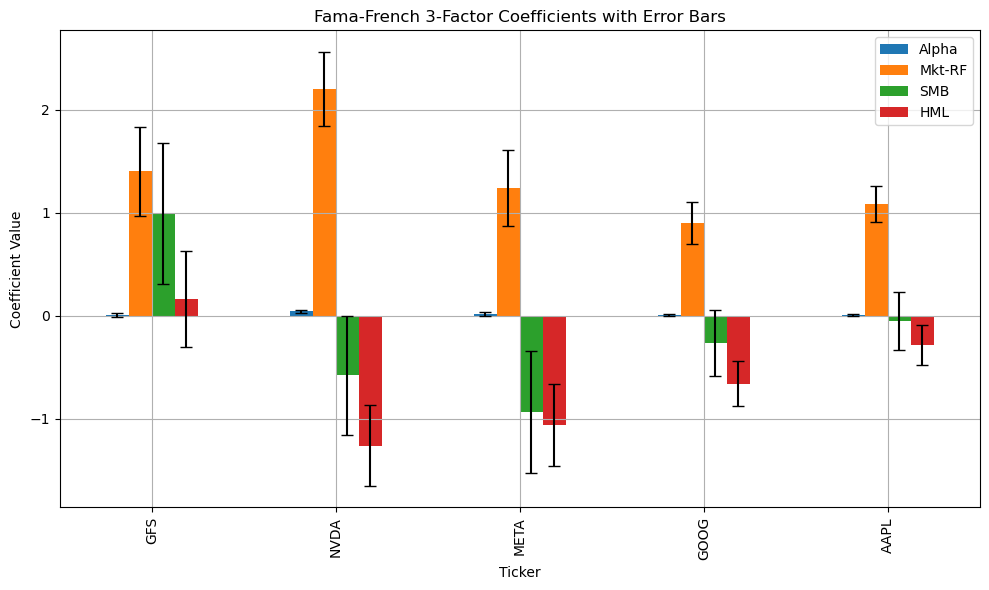

Ticker           GFS      NVDA      META      GOOG      AAPL
Alpha       0.002159  0.040245  0.013559  0.000914  0.006434
Mkt-RF      1.399550  2.198179  1.237045  0.900527  1.080997
SMB         0.991689 -0.579819 -0.935493 -0.267742 -0.051164
HML         0.158873 -1.263148 -1.061859 -0.662395 -0.285686
Alpha_err   0.020547  0.017244  0.017677  0.009658  0.008432
Mkt-RF_err  0.430951  0.361668  0.370756  0.202570  0.176844
SMB_err     0.688060  0.577443  0.591954  0.323426  0.282351
HML_err     0.465140  0.390361  0.400170  0.218641  0.190874


In [16]:
# Step 5: Generate Regression summary and Coefficients for Alpha, Mkt-RF, SMB, HML per Ticker
# Initialize lists
model,coef_df = ff3_regression_analysis(merged_data)
print (coef_df)

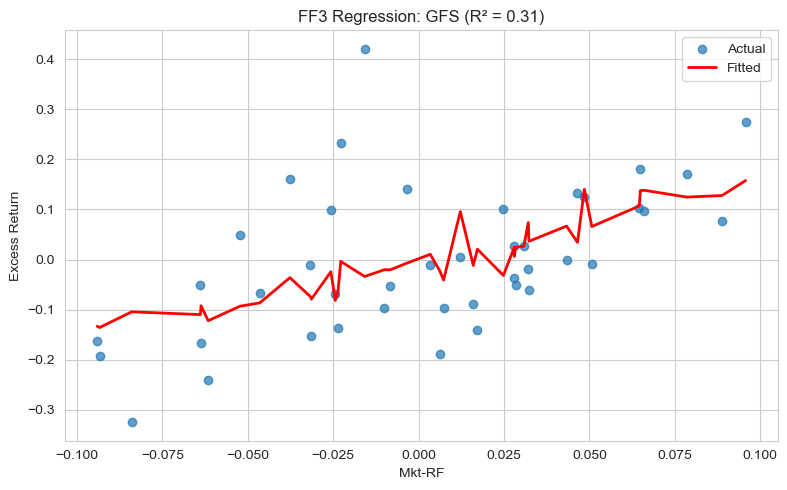

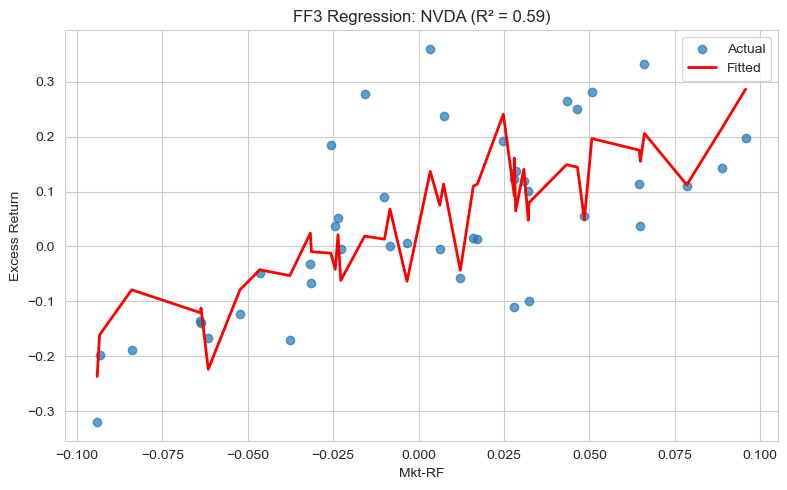

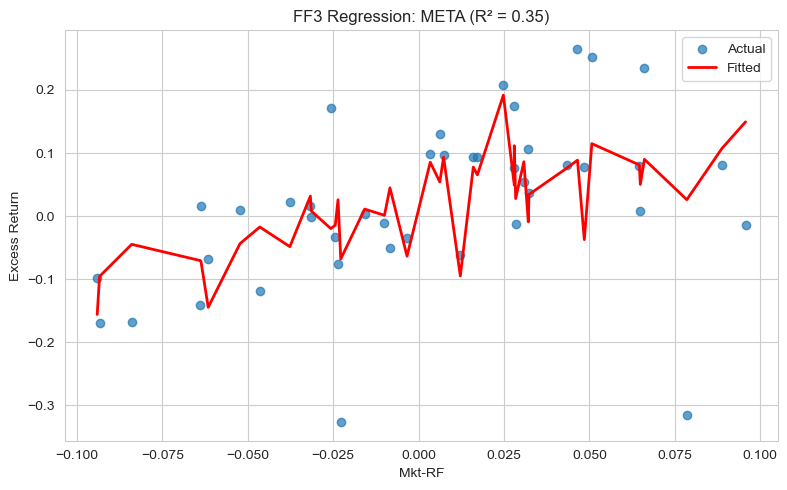

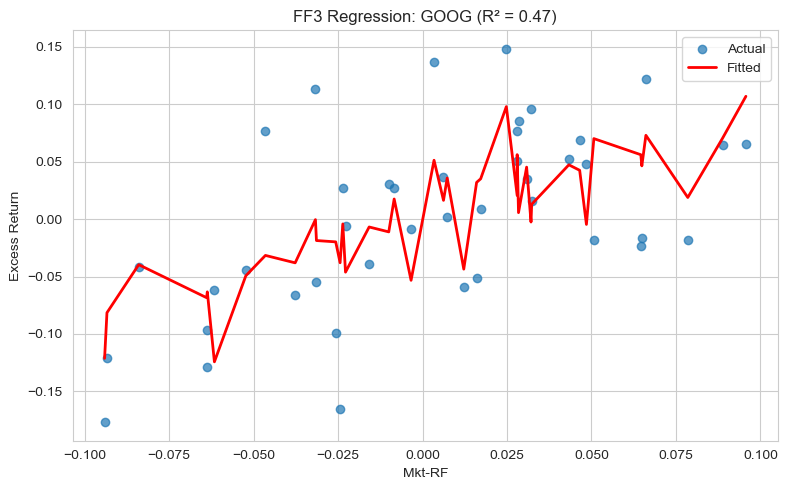

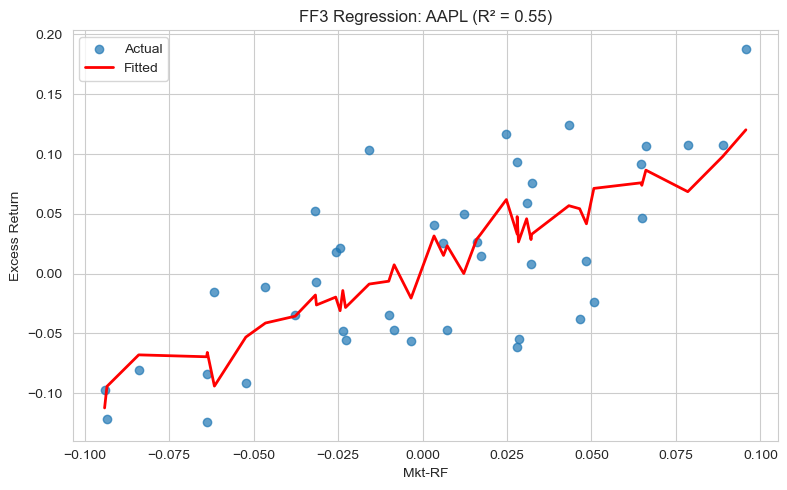

In [17]:
# Step 6: Plotting actual vs.fitted regression per ticker
ff3_fitted_plt(merged_data)


🎯 Risk Aversion Level (higher = more conservative):
 - 1–5   ➜ Aggressive (maximize returns)
 - 10–20 ➜ Balanced (moderate risk-return trade-off)
 - 30+   ➜ Conservative (prefer low volatility)


Enter your risk aversion level (e.g., 10):  15



✅ Optimized Portfolio Weights:
  Ticker  Weight (%)
0   AAPL       55.70
1    GFS        0.00
2   GOOG       34.81
3   META        9.49
4   NVDA        0.00


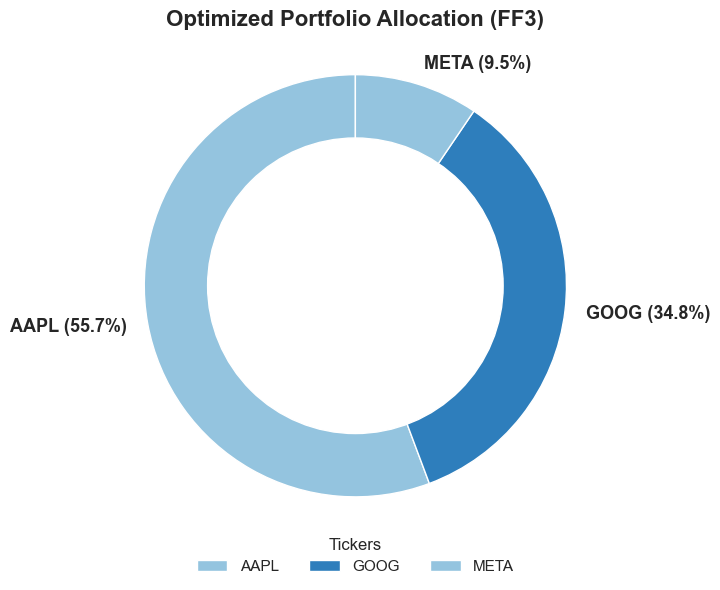

In [18]:
# Step 7: Portfolio optimization with FF3 Model
# Prompt user
if len(tickers) > 1:
    # Ask user to input risk aversion level
    print("\n🎯 Risk Aversion Level (higher = more conservative):")
    print(" - 1–5   ➜ Aggressive (maximize returns)")
    print(" - 10–20 ➜ Balanced (moderate risk-return trade-off)")
    print(" - 30+   ➜ Conservative (prefer low volatility)")
    try:
        risk_aversion = float(input("Enter your risk aversion level (e.g., 10): ").strip())
    except ValueError:
        print("❌ Invalid input. Using default: 10")
        risk_aversion = 10

    # 1. Compute average factor values per ticker
    mean_merged_data = merged_data.groupby('Ticker').mean(numeric_only=True)

    # 2. Sort coefficient DataFrame to align with tickers
    coef_df = coef_df[sorted(coef_df.columns)]

    # 3. Extract alpha and factor loadings
    alpha    = coef_df.T['Alpha'].values
    beta_mkt = coef_df.T['Mkt-RF'].values
    beta_smb = coef_df.T['SMB'].values
    beta_hml = coef_df.T['HML'].values

    # 4. Compute expected excess return using FF3 model
    expected_excess_return = (
        alpha
        + beta_mkt * mean_merged_data['Mkt-RF'].values
        + beta_smb * mean_merged_data['SMB'].values
        + beta_hml * mean_merged_data['HML'].values
    )

    # 5. Compute covariance matrix of returns (match ticker order)
    tickers = coef_df.columns.tolist()
    cov_matrix = returns[tickers].cov().values

    # 6. Optimize portfolio weights
    portfolio_weights = optimize_portfolio_ff3_risk_adjusted(
        expected_excess_return,
        cov_matrix,
        tickers,
        risk_aversion
    )

    # 7. Display final results
    portfolio_weights['Weight (%)'] = (portfolio_weights['Weight'] * 100).round(2)
    print("\n✅ Optimized Portfolio Weights:")
    print(portfolio_weights[['Ticker', 'Weight (%)']])
    plot_portfolio_pie(portfolio_weights)
else:
    print("⚠️ Not enough tickers to perform optimization.")


[*********************100%***********************]  1 of 1 completed


Input S&P500 as benchmark? (y/n):  y


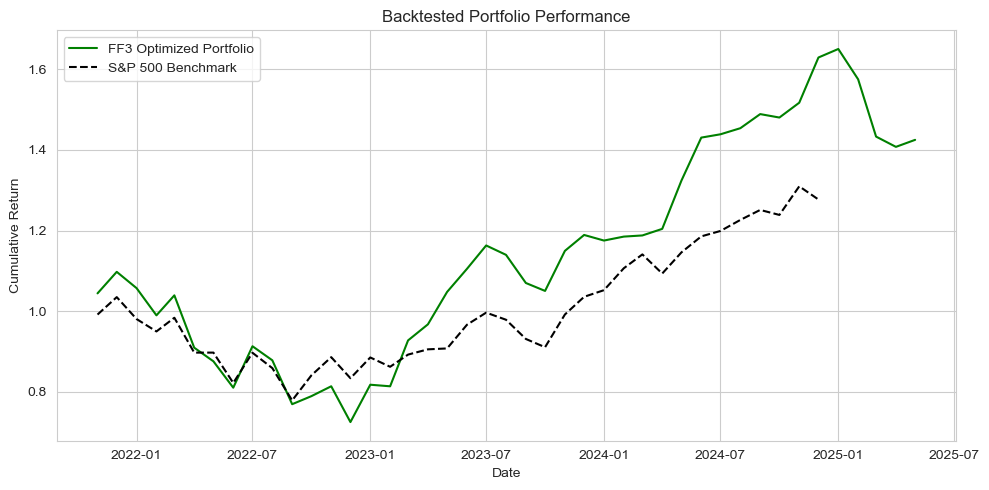

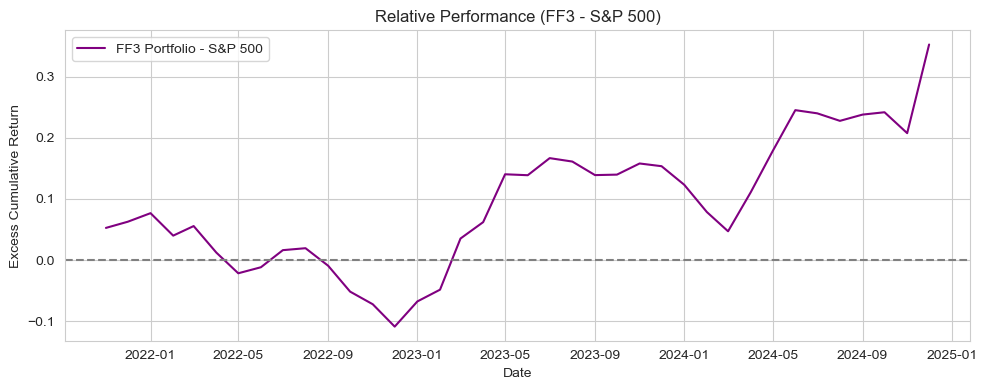

In [19]:
# Step 8: Backtesting w/ and w/o S&P500 and drawdown/relative performance to S&P500
# Download S&P 500 daily data
snp = yf.download('^GSPC', start='2020-01-01', end='2025-01-01', interval='1d', auto_adjust=True)

# Resample to monthly and compute returns
snp_monthly = snp['Close'].resample('ME').last()
snp_returns = snp_monthly.pct_change().dropna()

# Optional: Rename for clarity
snp_returns.name = snp_response = input("Input S&P500 as benchmark? (y/n): ").strip().lower()

if snp_response == 'y':
    portfolio_returns, benchmark_returns = backtest_portfolio(portfolio_weights, returns, snp_returns)
    plot_relative_performance(portfolio_returns, benchmark_returns)
else:
    backtest_portfolio(portfolio_weights, returns)

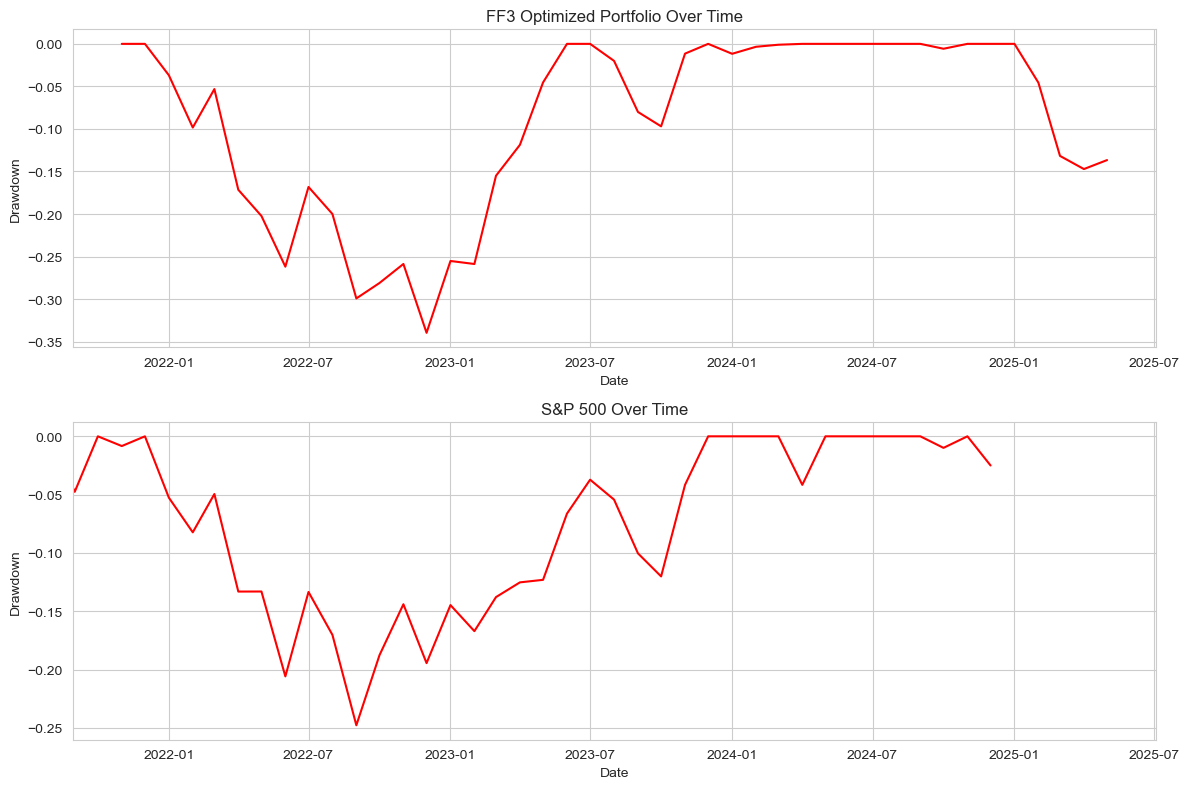

In [20]:
#Plot drawdown plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
# FF3 Portfolio
plot_drawdown(portfolio_returns, label="FF3 Optimized Portfolio", ax=ax1)
# S&P 500
plot_drawdown(benchmark_returns, label="S&P 500", ax=ax2)
# Force same x-axis limits
ax2.set_xlim(ax1.get_xlim())
plt.tight_layout()
plt.show()

In [21]:
#Portfolio Performance vs. Benchmark (S&P500) Summary 
performance_summary(portfolio_returns, label="FF3 Optimized Portfolio")
if benchmark_returns is not None:
    performance_summary(benchmark_returns, label="S&P 500")


Performance Summary: FF3 Optimized Portfolio
Total Return             : 42.52%
Annualized Return        : 10.39%
Annualized Volatility    : 22.46%
Sharpe Ratio             : 0.46
Max Drawdown             : -33.96%

Performance Summary: S&P 500
Total Return             : 82.35%
Annualized Return        : 13.00%
Annualized Volatility    : 18.33%
Sharpe Ratio             : 0.71
Max Drawdown             : -24.77%


In [ ]:
# Ask user whether to save outputs
if input("Save all outputs to CSV? (y/n): ").strip().lower() == 'y':
    # Define all outputs
   # Get raw metrics from performance_summary
    ff3_metrics = performance_summary(portfolio_returns, label="FF3 Optimized Portfolio")
    if benchmark_returns is not None:
        sp_metrics = performance_summary(benchmark_returns, label="S&P 500")
     
    outputs = {
        "merged_data.csv": merged_data,
        "portfolio_returns.csv": portfolio_returns,
        "benchmark_returns.csv": benchmark_returns if benchmark_returns is not None else None,
        "performance_summary.csv": pd.DataFrame({
            "Metric": list(ff3_metrics.keys()),
            "FF3 Optimized": list(ff3_metrics.values()),
            "S&P 500": list(sp_metrics.values()) if benchmark_returns is not None else [None]*5
        }),
        "regression_coefficients.csv": coef_df if 'coef_df' in locals() else None
    }

    # Save each available output
    for name, df in outputs.items():
        if df is not None:
            file_path = f"data/FF3_output/{name}.csv"
            df.to_csv(file_path, index=True)
            print(f"✅ {name}.csv saved.")
            print(f"📄 {name.replace('_', ' ').title()} data saved to {file_path}\n")
        else:
            print(f"⚠️ {name}.csv not available.")
else:
    print("❌ Save cancelled.")

Save all outputs to CSV? (y/n):  n


❌ Save cancelled.
